# QBC Quality control figure for paper

In [1]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [64]:
import zarr
from scip.masking import threshold, spot
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize

In [4]:
data_root = Path("/home/maximl/scratch/data/vsc/datasets/wbc/")

In [7]:
data_root = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/wbc"

In [8]:
data_scip = data_root / "scip/20220713131400/"

In [9]:
df_scip = pq.read_table(data_scip / "features.parquet").to_pandas()

df_scip["meta_group"] = df_scip["meta_group"].astype(int)

cat_type = CategoricalDtype(
    categories=sorted(df_scip["meta_part"].astype(int).unique()), ordered=True)
df_scip["meta_part"] = df_scip["meta_part"].astype(int).astype(cat_type)

df_scip = df_scip.set_index(["meta_group", "meta_part", "meta_fix", "meta_object_number"])
df_scip.columns = ["meta"+c[len("meta_threshold"):] if any(m in c for m in ["bbox", "regions"]) else c for c in df_scip.columns]

df_scip = df_scip[numpy.load(
    data_scip / "indices/columns.npy", allow_pickle=True)]
df_scip = df_scip.loc[numpy.load(
    data_scip / "indices/index.npy", allow_pickle=True)]

df_scip.index = df_scip.index.set_levels([2, 3, 4], level="meta_group")

df_scip["meta_label"] = pandas.Categorical(df_scip["meta_label"], ordered=True)

df_scip.shape

(218404, 3923)

In [114]:
channel_ind = [0, 8, 5]
channel_names = ["BF1", "BF2", "SSC"]
n = 10

In [115]:
sel1 = df_scip["feat_spot_area_SSC"] < 100
sel2 = df_scip["feat_spot_area_SSC"] > 10

spot_cells = df_scip[sel1 & sel2]

In [116]:
pixels = []
masks = dict(threshold=[], spot=[])
for i in range(n):
    r = spot_cells.iloc[i]
    z = zarr.open(r.meta_path)
    pixels.append(
        z[r.meta_zarr_idx].reshape(z.attrs["shape"][r.meta_zarr_idx])[channel_ind]
    )
    masks["threshold"].append(threshold.get_mask(dict(pixels=pixels[-1]), 0, smooth=[0.5, 0, 0.5])["mask"])
    masks["spot"].append(spot.get_mask(dict(pixels=pixels[-1]), 0, spotsize=20)["mask"])

In [117]:
basec = plt.get_cmap("Reds")(100)[:3]
cm = LinearSegmentedColormap.from_list(
    "test", 
    [basec + (0,), basec + (1,)],
    N=2
)

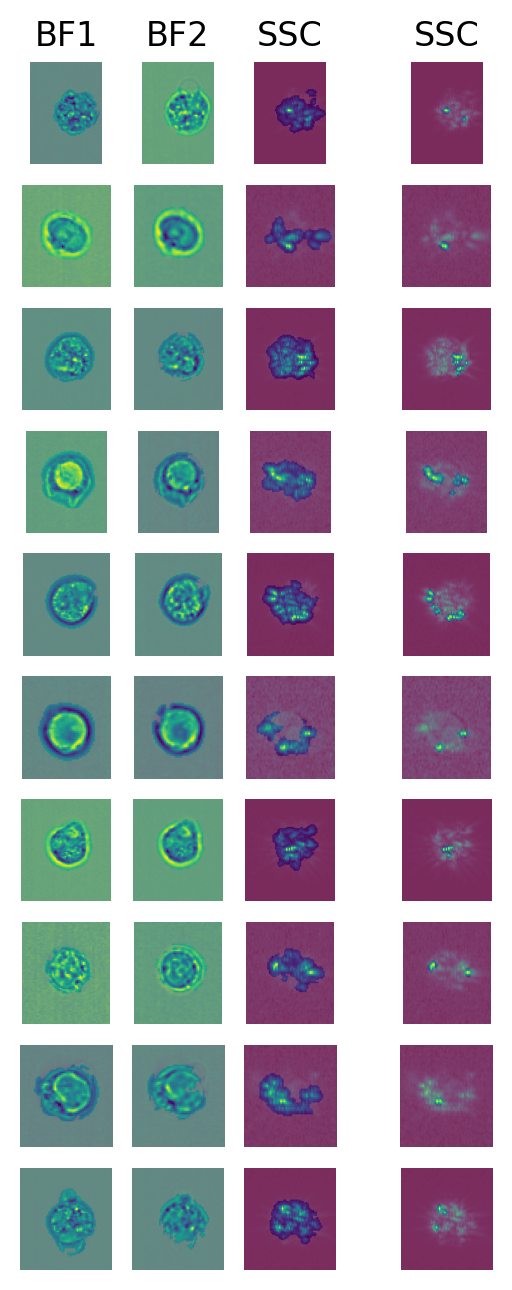

In [119]:
fig = plt.figure(dpi=200, figsize=(len(channel_ind)*1.5, n*0.8))
grid = gridspec.GridSpec(1, 2, figure=fig, wspace=0.2)
cmap = plt.get_cmap('viridis')

gs = {
    k: grid[0, i].subgridspec(n, len(channel_ind))
    for i, (k, v) in enumerate(masks.items())
}
for k, v in masks.items():
    for i, (mask, pixel) in enumerate(zip(v, pixels)):
        if k == "spot":
            mask = mask[[2]]
            pixel = pixel[[2]]
        for j, (m, p) in enumerate(zip(mask, pixel)):
            ax = plt.Subplot(fig, gs[k][i, j])
            ax.imshow(p)
            ax.imshow(cm(~m), alpha=0.3)
            ax.set_axis_off()
            fig.add_subplot(ax)
            if i == 0:
                if k == "spot":
                    ax.set_title(channel_names[2])
                else:
                    ax.set_title(channel_names[j])